In [13]:
import sys
sys.path.append('..')
from model.models import GraphEncoder, MoleculeEncoder, ConcatEncoder
import torch, json, os, pickle
from sklearn.manifold import TSNE
from utils.dataset import MoleculeDataset, fpolyv1_collate_fn, fpolyv2_collate_fn, to_tensor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import plotly.express as px
from pathlib import Path
from ypack.utils.plots import save_vector_image
from torch_geometric.nn import global_mean_pool
import tqdm

In [2]:
df = pd.read_csv('../dataset/fpolymers_221123.csv')
col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']
df = df[~df['TG'].isna()]
wdf = df[col_w].fillna(0)
wmasks = []
for x in 'ABCDE':
    wmasks.append(df.loc[wdf[f'FR_{x}'] == 0, 'ID'].values)
    print(x, len(wmasks[-1]))

A 52
B 65
C 85
D 130
E 19


In [3]:
df[col_s + col_w]
w_dict = {}
for s in df.SMILES_A.drop_duplicates():
    mask = df.SMILES_A == s
    w_dict[s] = df.loc[mask, col_w].sum(0).values

In [4]:
w_dict

{'CC(=C)C(=O)OCC(F)(F)F': array([32., 13., 10.,  3., 14.]),
 'CC(=C)C(=O)OCc1c(c(c(c(c1F)F)F)F)F': array([32., 11., 10.,  3., 14.]),
 'CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F': array([20.,  7., 10.,  3., 10.]),
 'CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': array([24., 11., 10.,  3., 12.]),
 'FC(F)(F)COC(=O)C=C': array([41., 22., 48.,  9., 30.]),
 'FC(F)(F)C(OC(=O)C=C)C(F)(F)F': array([34., 13., 14.,  3., 16.]),
 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C': array([109.,  35.,  48.,  26.,  42.]),
 'C=CC(=O)OCC(C(C(F)(F)F)F)(F)F': array([28.,  7., 10.,  3., 12.]),
 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C': array([20.,  7., 10.,  3., 10.]),
 'CC(=C)C(=O)OCC(F)(F)C(F)F': array([32., 11., 10.,  3., 14.]),
 'CC(=C)C(=O)OCC(C(F)(F)F)(F)F': array([161.6 , 297.88, 365.92,  59.59, 215.17]),
 'CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)F': array([34.19, 13.34, 14.93,  5.32, 16.52]),
 'CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F': array([33.72, 13.42, 15.07,  5.4

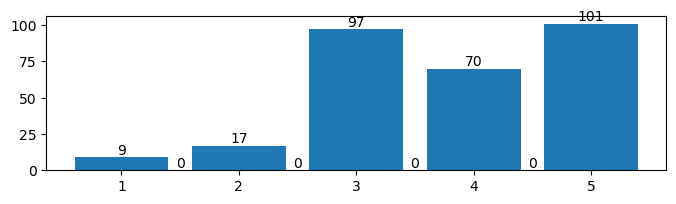

In [11]:
counts = (wdf != 0).sum(axis=1).values
c, b = np.histogram(counts, bins=np.linspace(0.5,5.5,11))
plt.figure(figsize=(8,2))
b = plt.bar(b[1:-1], c[1:])
_ = plt.bar_label(b)

In [5]:
smiles_e = df.SMILES_E[df.FR_E != 0]
for s in smiles_e.drop_duplicates():
    for x in 'ABCDE':
        m = df[f'FR_{x}'] != 0
        print(x, s, np.sum(df.loc[m, f'SMILES_{x}'] == s))


A CC(=C)C(=O)OCCO 0
B CC(=C)C(=O)OCCO 0
C CC(=C)C(=O)OCCO 0
D CC(=C)C(=O)OCCO 0
E CC(=C)C(=O)OCCO 243
A OCCOC(=O)C=C 0
B OCCOC(=O)C=C 0
C OCCOC(=O)C=C 0
D OCCOC(=O)C=C 0
E OCCOC(=O)C=C 7
A CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
B CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 1
C CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
D CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
E CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 33


In [13]:
for x in 'ABCDE':
    m = []
    for s in df[f'SMILES_{x}']:
        m.append('F' in s)
    print(x, np.sum(m), len(m))

A 290 294
B 17 294
C 0 294
D 0 294
E 0 294


array([[<AxesSubplot: title={'center': 'FR_A'}>,
        <AxesSubplot: title={'center': 'FR_B'}>,
        <AxesSubplot: title={'center': 'FR_C'}>,
        <AxesSubplot: title={'center': 'FR_D'}>,
        <AxesSubplot: title={'center': 'FR_E'}>]], dtype=object)

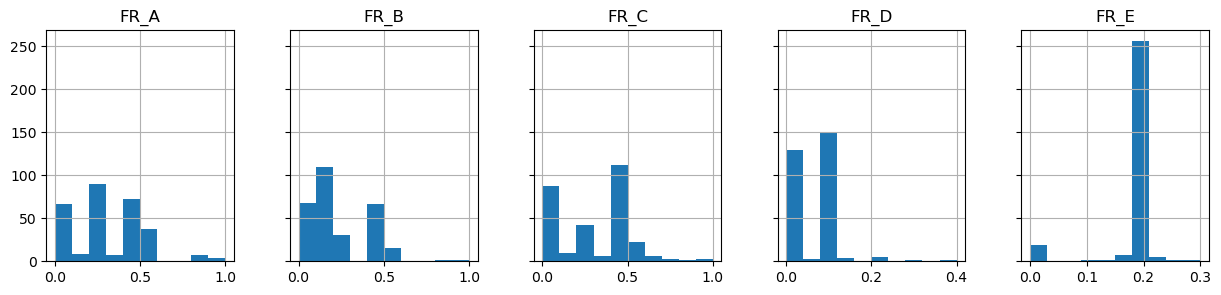

In [6]:
nwdf = wdf / wdf.sum(1).values.reshape(-1,1)
nwdf[col_w].hist(layout=(1,5), figsize=(15,3), sharey=True)

In [6]:
md0 = MoleculeDataset()
md0.generate_fpolyv1('../dataset/fpolymers_221123.csv')

parsing input data: 100%|██████████| 294/294 [00:00<00:00, 2439.41it/s]


In [5]:
md1 = MoleculeDataset()
md1.generate_fpolyv1('../dataset/screen_02.csv')
#md1.generate_fpolyv1('../dataset/fpolymers_221123.csv')

parsing input data: 100%|██████████| 228720/228720 [01:32<00:00, 2471.98it/s]


In [15]:
def to_vector(data, c = 1):
    feat, target, ids = fpolyv1_collate_fn(data)
    
    ws = [m['weight'] for m in feat.values()]
    if c == 1:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 2:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).max(dim=0).values.numpy()
    elif c == 3:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 4:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).max(dim=0).values.numpy()
    return ff, target.numpy(), ids

root = '/home/jhyang/WORKSPACES/vecs/feat'
#fdf = pd.read_csv('../dataset/screen_01.csv')
ids = []
#for c, fn in enumerate(['mol_avg.txt','mol_max.txt','atm_avg.txt','atm_max.txt']):
for c, fn in [[3, 'atm_avg_u.txt'],[4, 'atm_max_u.txt']]:
    vec, _, _ids = to_vector(to_tensor(md0.data, device='cpu'), c)
    with open(os.path.join(root, fn), 'wb') as f:
        np.savetxt(f, vec, fmt='%.7f')
    for i in range(len(md1)//5000 + 1):
        vec, _, _ids = to_vector(to_tensor(md1.data[i*5000:(i+1)*5000], device='cpu'), c)
        with open(os.path.join(root, fn), 'ab') as f:
            np.savetxt(f, vec, fmt='%.7f')

In [19]:
np.loadtxt(os.path.join(root, fn)).shape

(229014, 26)

In [107]:
import json
with open(os.path.join(root, 'ids.txt'), 'w') as f:
    json.dump(ids.tolist(), f, indent=4)

In [18]:
np.array(ws).shape, np.array(afs).shape, np.array(mfs).shape

((5, 2193654, 1), (5, 2193654, 26), (5, 2193654, 399))

In [537]:
mfs = [m['mol_feat'] for m in feat.values()]
afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
ws = [m['weight'] for m in feat.values()]
mapf = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).sum(dim=0).numpy()
mmpf = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).max(dim=0).values.numpy()
aapf = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).sum(dim=0).numpy()
ampf = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).max(dim=0).values.numpy()

vecs = []
for fs in [mapf, mmpf, aapf, ampf]:
    tsne = TSNE(init='pca', learning_rate='auto')
    vec = tsne.fit_transform(fs)
    vmax = np.max(vec, axis=0)
    vmin = np.min(vec, axis=0)
    nvec = (vec - vmin *0.5 - vmax * 0.5)/(vmax - vmin)
    vecs.append(nvec)

/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in

In [9]:
def to_vector(data, c = 1):
    feat, target, ids = fpolyv1_collate_fn(data)
    
    ws = [m['weight'] for m in feat.values()]
    if c == 1:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 2:
        mfs = [m['mol_feat'] for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(mfs, ws)], dim=0).max(dim=0).values.numpy()
    elif c == 3:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).sum(dim=0).numpy()
    elif c == 4:
        afs = [global_mean_pool(m['atom_feat'], m['graph_idx']) for m in feat.values()]
        ff = torch.stack([_f * _w for _f, _w in zip(afs, ws)], dim=0).max(dim=0).values.numpy()
    return ff, target.numpy(), ids


In [32]:
vecs = []
for i in range(4):
    feat, target, ids = to_vector(md1.data, i+1)
    vecs.append(feat)

In [24]:
vec.shape

(294, 2)

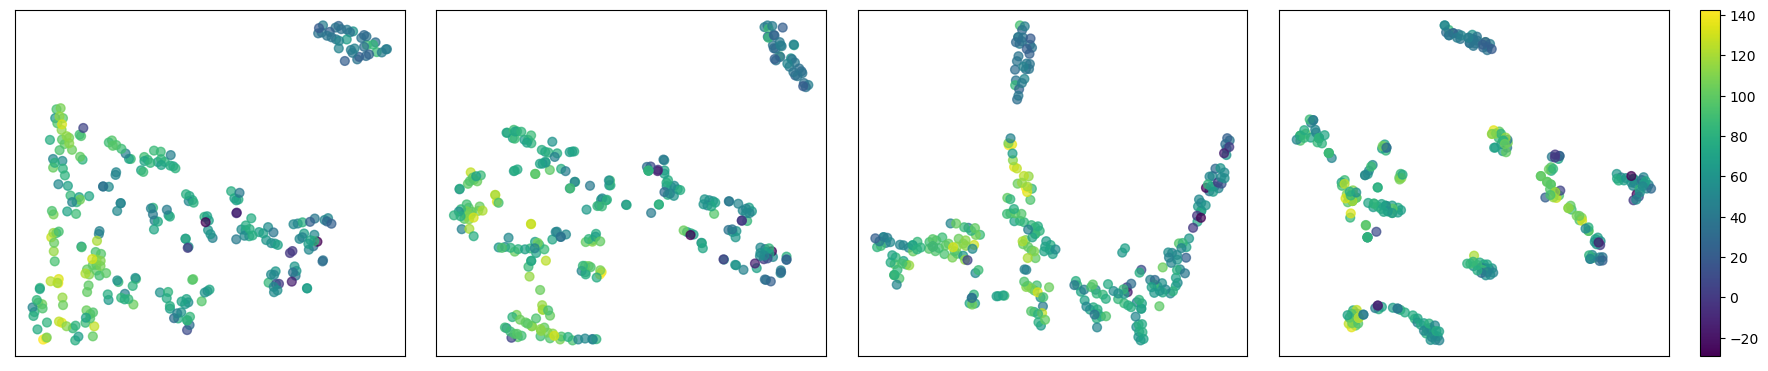

In [46]:
f, axs = plt.subplots(1,5,figsize=(22, 4.5), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for ax, feat in zip(axs, vecs):
    tsne = TSNE(init='pca', perplexity=15)
    tvec = tsne.fit_transform(feat)
    vmax = np.max(tvec, axis=0)
    vmin = np.min(tvec, axis=0)
    vec = (tvec - vmin *0.5 - vmax * 0.5)/(vmax - vmin)
    lbl = ''
    for i in np.where(target < 0)[0]:
        lbl += f'{ids[i]} / {target[i].item():7.2f}K / {vec[i,0]:5.2f}, {vec[i,1]:5.2f}\n'
    im = ax.scatter(*vec.T, c=target, s=40, alpha=0.7)
#    ax.scatter(*vec[np.where(target < 0)[0]].T, color=[1,1,1], edgecolor=[0,0,0], s=50)
    plt.colorbar(im, cax=axs[-1])
#    ax.text(-28,11,s=lbl)
#    ax.set_xlim([-6,6])
#    ax.set_ylim([-6,6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
f.subplots_adjust(wspace=0.1)

In [28]:
vec

array([[-2.24768791e+01, -3.74743104e+00],
       [-4.90527821e+00, -4.28851455e-01],
       [-2.61763954e+01, -2.38267660e+00],
       [-5.29565334e+00, -2.61688620e-01],
       [ 2.58470745e+01, -2.56684566e+00],
       [-2.44578018e+01,  4.96822566e-01],
       [-2.49560642e+00, -7.21814275e-01],
       [ 2.84037514e+01, -3.72779846e+00],
       [-2.39035778e+01,  9.05513227e-01],
       [-2.56717110e+00, -1.14586377e+00],
       [ 2.85556564e+01, -3.21189094e+00],
       [-2.26722393e+01, -3.34083915e+00],
       [-4.44724798e+00, -4.43476945e-01],
       [ 2.64208813e+01, -2.96666074e+00],
       [-2.38010502e+01, -5.29971957e-01],
       [-2.81571198e+00, -3.03820819e-01],
       [ 2.78758373e+01, -4.03422832e+00],
       [-2.35146294e+01,  4.90124524e-01],
       [-2.86659861e+00, -7.70116508e-01],
       [ 2.78324089e+01, -3.49662876e+00],
       [-2.30963860e+01, -1.07095587e+00],
       [-3.46513724e+00, -3.26419145e-01],
       [ 2.69917297e+01, -3.53742003e+00],
       [-2.

In [555]:

x1, y1 = vecs[0].T
x2, y2 = vecs[1].T
x3, y3 = vecs[2].T
m1 = x1 > 0.4
m2 = y2 > 0.3
m3 = y3 > 0.1
ids[m1], ids[m2], ids[m3]
# TSNE 상에서 분리된 영역에 존재함. test 데이터로 활용 시 볼 것?

(array(['FA-00298', 'FA-00301', 'FA-00353', 'FA-00411', 'FA-00412',
        'FA-00413', 'FA-00414', 'FA-00416', 'FA-00417', 'FA-00418',
        'FA-00419', 'FA-00420', 'FA-00421', 'FA-00422', 'FA-00424',
        'FA-00425', 'FA-00426', 'FA-00428', 'FA-00429', 'FA-00430',
        'FA-00431', 'FA-00432', 'FA-00433', 'FA-00434', 'FA-00435',
        'FA-00436', 'FA-00438', 'FA-00439', 'FA-00441', 'FA-00442',
        'FA-00443', 'FA-00444', 'FA-00445', 'FA-00447', 'FA-00448',
        'FA-00484'], dtype='<U8'),
 array(['FA-00298', 'FA-00301', 'FA-00353', 'FA-00411', 'FA-00412',
        'FA-00413', 'FA-00414', 'FA-00416', 'FA-00417', 'FA-00418',
        'FA-00419', 'FA-00420', 'FA-00421', 'FA-00422', 'FA-00424',
        'FA-00425', 'FA-00426', 'FA-00428', 'FA-00429', 'FA-00430',
        'FA-00431', 'FA-00432', 'FA-00433', 'FA-00434', 'FA-00435',
        'FA-00436', 'FA-00438', 'FA-00439', 'FA-00441', 'FA-00442',
        'FA-00443', 'FA-00444', 'FA-00445', 'FA-00447', 'FA-00448',
        'FA-0

In [579]:
for i, row in df.loc[ids[m2 & ~m3]].iterrows():
    s = row[col_s].values
    w = row[col_w].values
    print(i, 'F' in ' '.join(s[w != 0].tolist()))

FA-00298 False
FA-00301 False
FA-00353 False
FA-00425 True
FA-00430 True
FA-00447 False
FA-00448 False


In [626]:
pd.set_option('display.max_colwidth',100)
#df.loc[m1, ['SMILES_A','SMILES_B','SMILES_E'] + [f'FR_{x}' for x in 'ABE']]
counts = {}
for i, row in df[m1].iterrows():
    s = row[col_s].values
    w = row[col_w].values
    for _s in s[w != 0]:
        if _s not in counts.keys():
            counts[_s] = {'cnt':0, 'id':[], 'loc':[]}
        counts[_s]['cnt'] += 1
        counts[_s]['id'].append(i)
        counts[_s]['loc'].append(np.where((s == _s) & (w != 0))[0][0])

#for s in df[m1].SMILES_B.drop_duplicates():
#    print(s, np.sum(s == df[m1].SMILES_B))

In [634]:
s1 = ['CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C','CC(=C)C(=O)OCCO']
s2 = ['CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C','CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O']
counts_2 = {'1':{i:0 for i in range(2,6)},'2':{i:0 for i in range(2,6)}}
for i, row in df.iterrows():
    ss = row[col_s].values[row[col_w].values != 0].tolist()
    if s1[0] in ss and  s1[1] in ss:
        counts_2['1'][len(ss)] += 1
    if s2[0] in ss and  s2[1] in ss:
        counts_2['2'][len(ss)] += 1
counts_2

{'1': {2: 0, 3: 18, 4: 25, 5: 59}, '2': {2: 0, 3: 18, 4: 0, 5: 0}}

In [627]:
counts = {k:v for k,v in sorted(counts.items(), key=lambda x: x[1]['cnt'], reverse=True)}
for k, v in counts.items():
    locs = [np.sum(i == np.array(v['loc'])) for i in range(5)]
    print(k, v['cnt'], locs)

CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C 35 [0, 34, 1, 0, 0]
CC(=C)C(=O)OCCO 18 [0, 0, 0, 0, 18]
CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 18 [0, 0, 0, 0, 18]
COC(=O)C(C)=C 4 [1, 0, 3, 0, 0]
FC(F)(F)COC(=O)C=C 2 [2, 0, 0, 0, 0]
FC(F)(F)C(OC(=O)C=C)C(F)(F)F 2 [2, 0, 0, 0, 0]
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(F)(F)C(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(C(F)(F)F)(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(F)(F)[C@H](F)C(F)(F)F 2 [2, 0, 0, 0, 0]
FC(F)(F)C(F)(F)COC(=O)C=C 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCC(F)(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCc1c(c(c(c(c1F)F)F)F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F 2 [2, 0, 0, 0, 0]
CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F 2 [2, 0, 0, 0, 0]
CCCCCCCCCCCCCCCCCCOC(=O)C=C 1 [0, 1, 0, 0, 0]
CC(=C)C(=O)OCC1CCCO1 1 [0, 1, 0, 0, 0]
C=CC(=O)OCC(C(

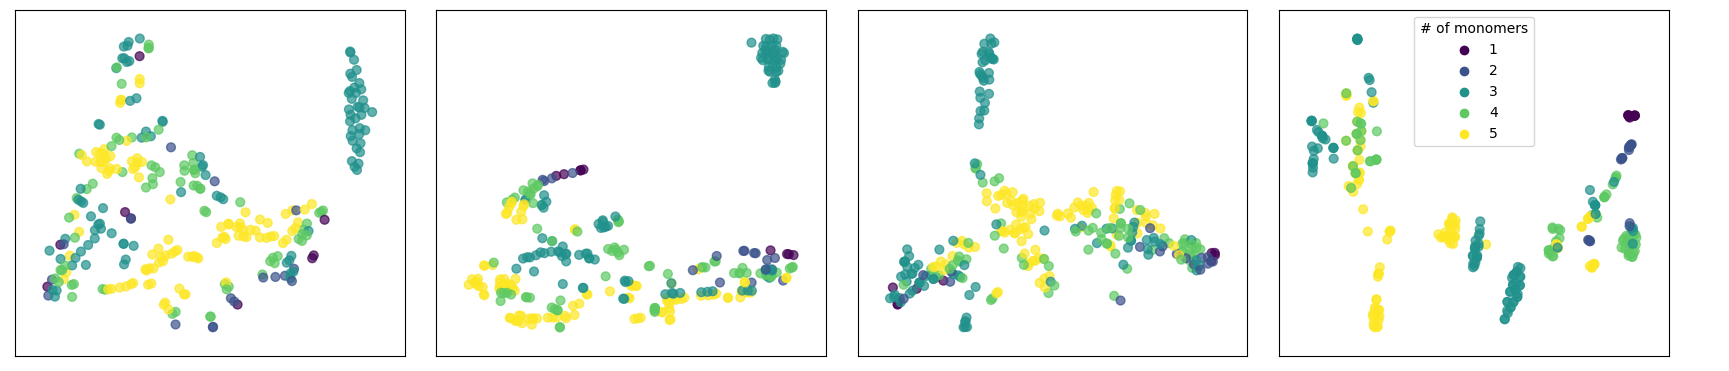

In [548]:
nmono = np.sum(torch.stack(ws).squeeze().T.numpy() != 0, axis=1)
f, axs = plt.subplots(1,5,figsize=(22, 4.5), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for ax, vec in zip(axs, vecs):
    im = ax.scatter(*vec.T, c=nmono, s=40, alpha=0.7)
    for i in range(5):
        ax.scatter(-40, 40, c=i, vmin=0, vmax=4, label=f'{i+1}')
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.6,0.6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
axs[-2].legend(loc='upper center', title='# of monomers')
axs[-1].axis('off')
f.subplots_adjust(wspace=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


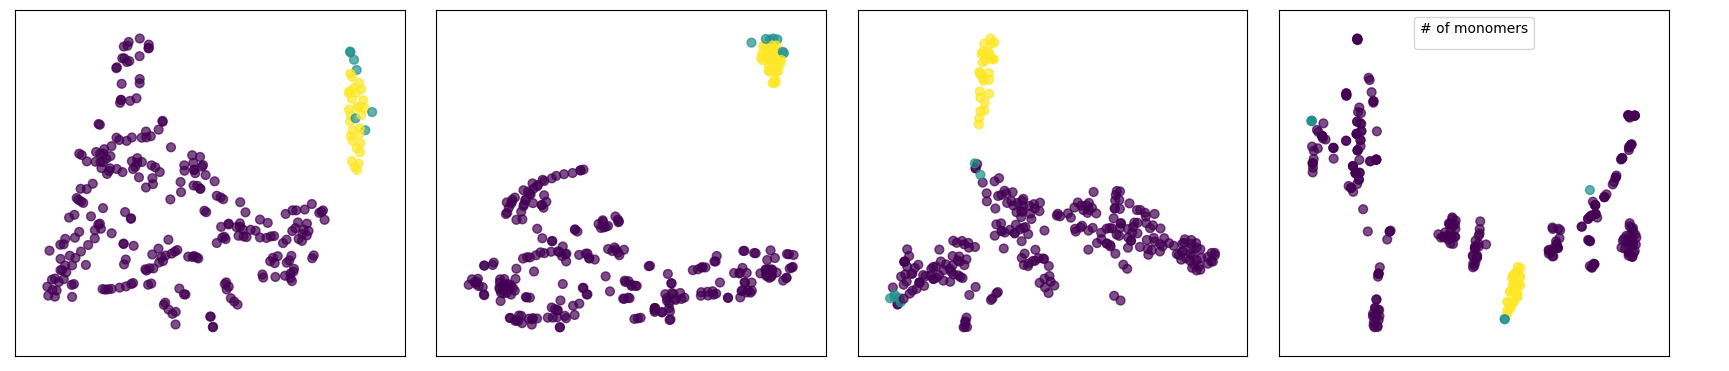

In [585]:
f, axs = plt.subplots(1,5,figsize=(22, 4.5), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for ax, vec in zip(axs, vecs):
    im = ax.scatter(*vec.T, c=m1.astype(int) + m3.astype(int), s=40, alpha=0.7)
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.6,0.6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
axs[-1].axis('off')
f.subplots_adjust(wspace=0.1)

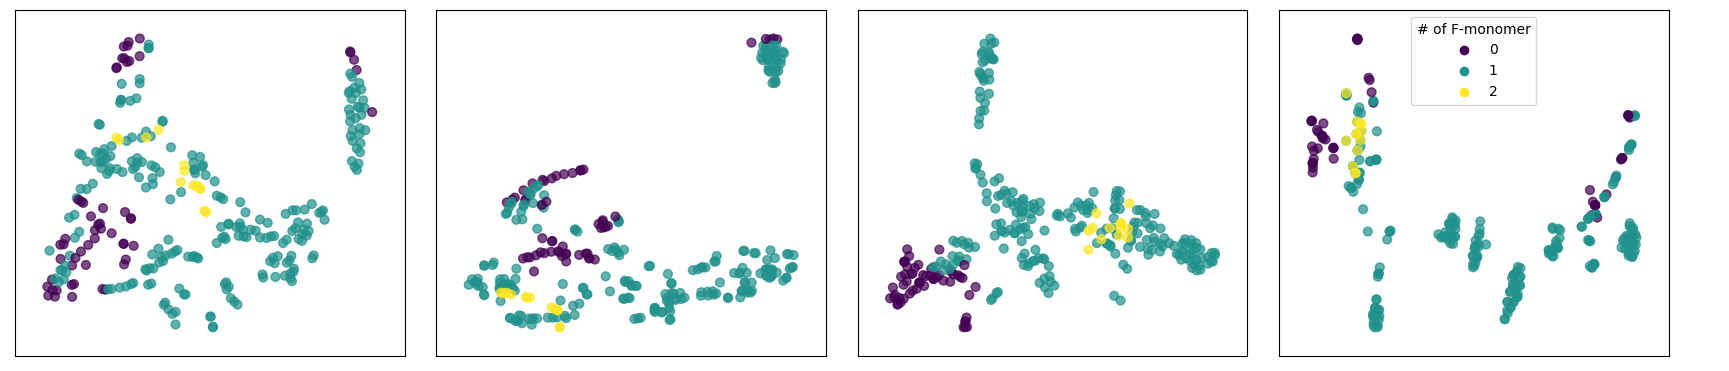

In [582]:
isfluo = []
for id, row in df.loc[ids].iterrows():
    s = row[col_s].values
    m = (row[col_w] != 0).values
    isfluo.append(np.sum(['F' in _s for _s in s[m]]))
f, axs = plt.subplots(1,5,figsize=(22, 4.5), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for ax, vec in zip(axs, vecs):
    ax.scatter(*vec.T, c=isfluo, s=40, alpha=0.7)
    for i in sorted(np.unique(isfluo)):
        ax.scatter(-40,40,c=i,label=f'{i}', vmin=0, vmax=np.max(isfluo))
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.6,0.6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
axs[-2].legend(loc='upper center', title='# of F-monomer')
axs[-1].axis('off')
f.subplots_adjust(wspace=0.1)

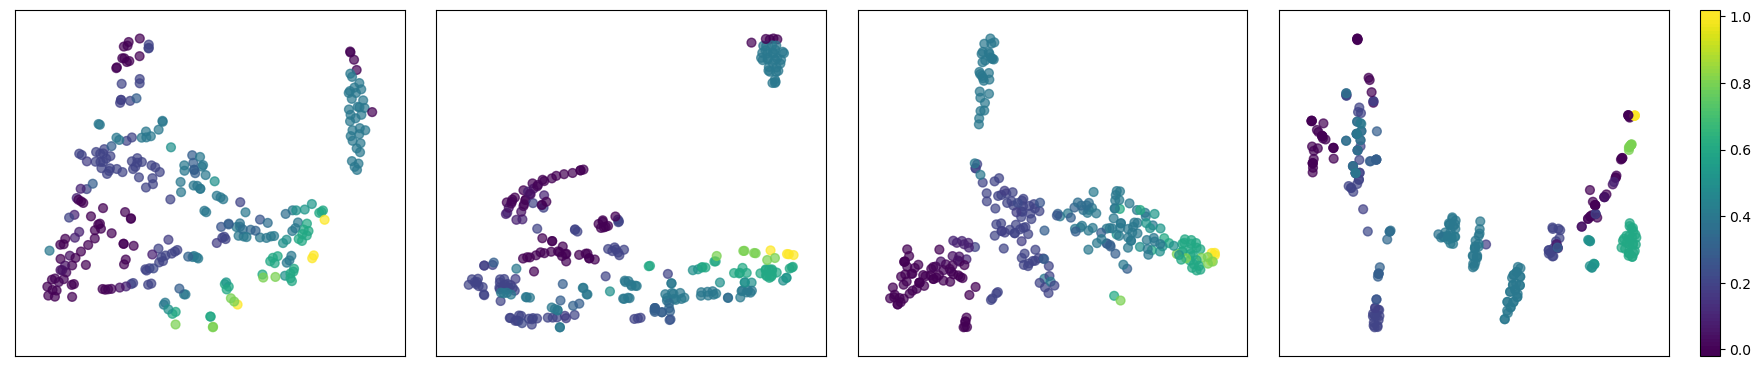

In [557]:
frate = []
for id, row in df.loc[ids].iterrows():
    s = row[col_s].values
    w = row[col_w].values
    m = ['F' in _s for _s in s]
    frate.append(np.sum(w[m])/np.sum(w))
    
f, axs = plt.subplots(1,5,figsize=(22, 4.5), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for ax, vec in zip(axs, vecs):
    im = ax.scatter(*vec.T, c=frate, s=40, alpha=0.7, vmin=0, vmax=1)
    plt.colorbar(im, cax=axs[-1], boundaries=np.linspace(-0.02,1.02,100), ticks=np.linspace(0,1,6))
    ax.set_xlim([-0.6,.6])
    ax.set_ylim([-0.6,0.6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
f.subplots_adjust(wspace=0.1)

Text(0, 0.5, 'Fraction of F-monomer')

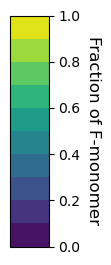

In [410]:
f, ax = plt.subplots(1,1,figsize=(0.5,3))
im = plt.scatter([0,1],[0,1],c=[0,1],vmin=0,vmax=1)
plt.colorbar(im, cax=ax, boundaries=np.linspace(0.,1,11), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel('Fraction of F-monomer', fontsize=12, rotation=-90, labelpad=15)

(0.0, 115.0)

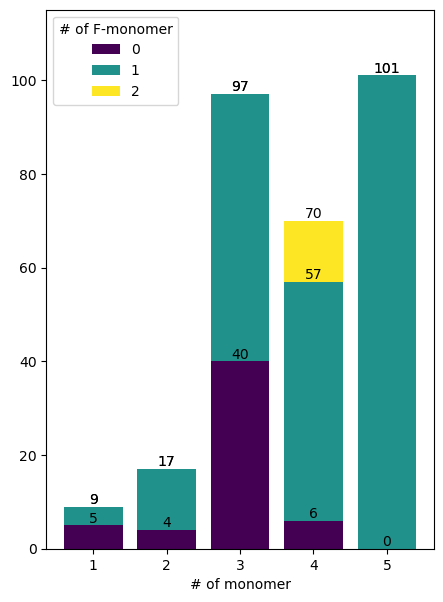

In [326]:
ys = []
cmap = plt.get_cmap('viridis')
for i in range(1,6):
    m = np.array(nmono) == i    
    ys.append([np.sum(j == np.array(isfluo)[m]) for j in range(3)])
f, ax = plt.subplots(1,1,figsize=(5,7))
x = np.array([1,2,3,4,5])
z = np.array([0,0,0,0,0])
for i, y in enumerate(np.array(ys).T):
    bars = ax.bar(x, y, bottom=z, color=cmap(i/2), label=f'{i}')
    ax.bar_label(bars)
    z += y
ax.legend(loc='upper left',title='# of F-monomer')
ax.set_xlabel('# of monomer')
ax.set_ylim([0,115])

In [365]:
m = np.array(nmono) == 1
c, _ = np.histogram(np.array(frate)[m], bins=[-0.1,0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
labels = ['< 0.1', '0.1 ~ 0.3', '0.3 ~ 0.5', '0.5 ~ 0.7', '0.7 ~ 0.9', '0.9 >']
np.array(frate)[m]

array([0., 0., 0., 1., 1., 1., 1., 0., 0.])

(0.0, 115.0)

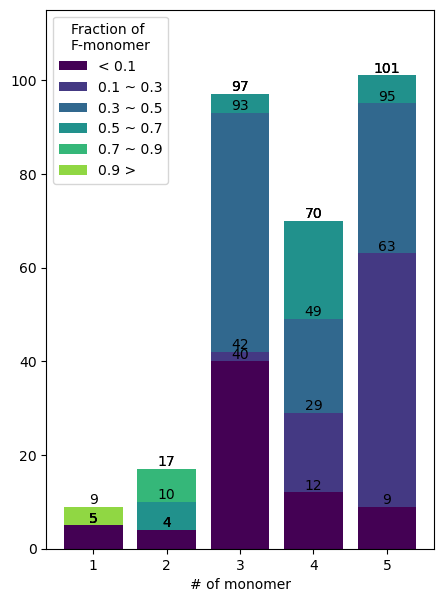

In [355]:
ys = []
cmap = plt.get_cmap('viridis')
for i in range(1,6):
    m = np.array(nmono) == i    
    c, _ = np.histogram(np.array(frate)[m], bins=[-0.1,0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
    ys.append(c)
f, ax = plt.subplots(1,1,figsize=(5,7))
x = np.array([1,2,3,4,5])
z = np.array([0,0,0,0,0])
for i, y in enumerate(np.array(ys).T):
    bars = ax.bar(x, y, bottom=z, color=cmap(i/len(labels)), label=labels[i])
    ax.bar_label(bars)
    z += y
ax.legend(loc='upper left',title='Fraction of\nF-monomer')
ax.set_xlabel('# of monomer')
ax.set_ylim([0,115])

(0.0, 115.0)

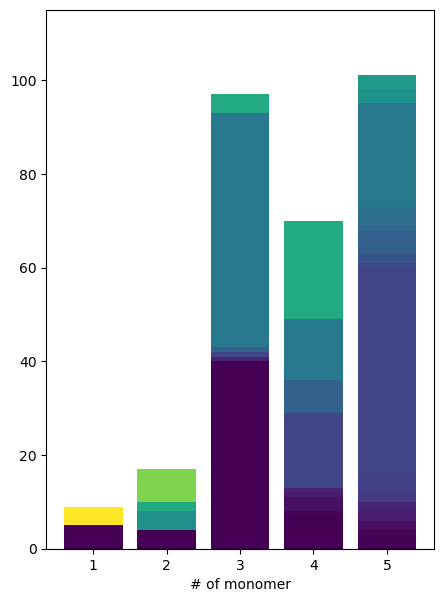

In [367]:
ys = []
cmap = plt.get_cmap('viridis')
for i in range(1,6):
    m = np.array(nmono) == i
    c, _ = np.histogram(np.array(frate)[m], bins=np.linspace(0,1,101))
    ys.append(c)
f, ax = plt.subplots(1,1,figsize=(5,7))
x = np.array([1,2,3,4,5])
z = np.array([0,0,0,0,0])
for i, y in enumerate(np.array(ys).T):
    bars = ax.bar(x, y, bottom=z, color=cmap(i/99))
    z += y
ax.set_xlabel('# of monomer')
ax.set_ylim([0,115])

In [432]:
xedg, yedg

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 array([-29.22999954, -25.79199959, -22.35399963, -18.91599968,
        -15.47799973, -12.03999977,  -8.60199982,  -5.16399986,
         -1.72599991,   1.71200005,   5.15      ,   8.58799995,
         12.02599991,  15.46399986,  18.90199982,  22.33999977,
         25.77799973,  29.21599968,  32.65399963,  36.09199959,
         39.52999954,  42.9679995 ,  46.40599945,  49.8439994 ,
         53.28199936,  56.71999931,  60.15799927,  63.59599922,
         67.03399918,  70.47199913,  73.90999908,  77.34799904,
         80.78599899,  84.22399895,  87.6619989 ,  91.09999886,
         94.53799881,  97.97599876, 101.41399872, 104.85199867,
        108.

(-0.02, 1.02)

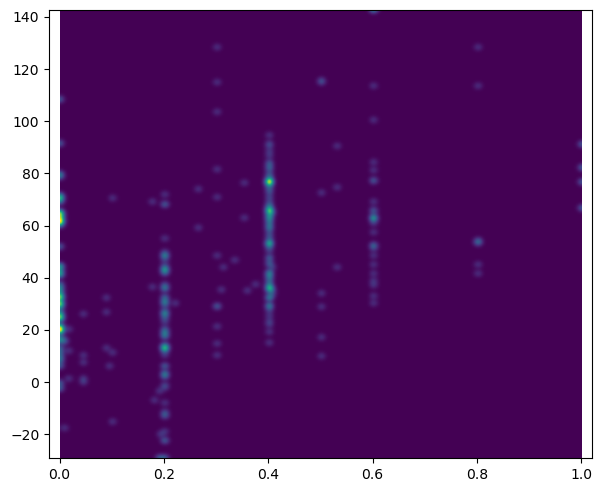

In [483]:
from scipy.ndimage.filters import gaussian_filter

np.corrcoef(frate, target.numpy().reshape(-1))[0,1]
hmap, x, y = np.histogram2d(frate, target.numpy().reshape(-1), bins=500)
hmap = gaussian_filter(hmap, sigma=3)
f, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(hmap.T, extent=[x[0],x[-1],y[0],y[-1]], aspect=0.005)
#ax.scatter(frate, target.numpy().reshape(-1))
ax.set_xlim([-0.02,1.02])


## Feature / Embeddings

In [6]:
def load_encoded_tvecs(fn, tag, root='/home/jhyang/WORKSPACES/tsne_gpu/', output=None):
    vpath = os.path.join(root, tag)
    n = fn.split('.')[0]
    mpath = vpath.replace('tsne_gpu','MODELS/fpoly/r100')
    with open(os.path.join(vpath, fn),'rb') as f:
        vd = pickle.load(f)
    errs = []
    
    for ds in ['train','valid','test']:
        with open(os.path.join(mpath, f'c_{n}/00200.{ds}.pkl'), 'rb') as f:
            id, t, p = pickle.load(f)
        err = t - p
        errs.append(err[np.argsort(id)].reshape(-1))
    vd['err'] = errs
    if output == 'df':
        dfs = []
        qvec = vd['qvec']
        train = vd['train']
        valid = vd['valid']
        test = vd['test']
        for i in range(5):
            df = pd.DataFrame()
            n0, n1, n2, n3 = qvec[i].shape[0], train[i].shape[0], valid[i].shape[0], test[i].shape[0]
            df[['x','y']] = np.vstack([qvec[i], train[i], valid[i], test[i]])
            df['encoder'] = 'ABCDE'[i]
            df['dataset'] = np.hstack([
                np.repeat('QM9',n0),
                np.repeat('Train',n1),
                np.repeat('Valid',n2),
                np.repeat('Test',n3)
            ])
            df['error'] = np.hstack([np.repeat(0,n0), *vd['err']])
            df['ids'] = np.hstack([np.repeat('',n0), *vd['ids']])
            dfs.append(df)
        return pd.concat(dfs)
    else:
        return vd

def draw_figures(fn, tag, root):
    global wmasks
    data = load_encoded_tvecs(fn=fn, tag=tag, root=root)
    f, axs = plt.subplots(3, 6, figsize=(30, 15), gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
    qvec = data['qvec']
    axs[0,0].set_title(fn)
    axs[0,1].set_title('R2: {:.2f} / {:.2f} / {:.2f}'.format(*data['r2']))
    axs[0,2].set_title('RMSE: {:.2f} / {:.2f} / {:.2f}'.format(*data['rmse']))
    for i, (dax, dset) in enumerate(zip(axs, ['train','valid','test'])):
        dvec = data[dset]
        errs = data['err'][i]
        ids  = pd.DataFrame(data['ids'][i])
        for j, ax in enumerate(dax[:-1]):
            mask = ~ids.isin(wmasks[j]).values.reshape(-1)
            ax.scatter(*qvec[j].T, color=[0.7,0.7,0.7], alpha=0.01, s=3)
            x, y = dvec[j][mask].T
            err = errs[mask]
            id  = ids.values[mask].reshape(-1)
            order = np.argsort(np.abs(err))
            im = ax.scatter(x[order], y[order], c=np.abs(err[order]), alpha=1, vmin=0, vmax=100, cmap='viridis_r')
            line = ''
            for k in np.where(np.abs(err) > 40)[0]:
                line += f'{id[k]} / {x[k]:.0f}, {y[k]:.0f} / {err[k]:.2f}\n'
            ax.text(-50,-50,line)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_yticklabels([])
        plt.colorbar(im, cax=dax[-1])
    f.subplots_adjust(wspace=0.05, hspace=0.05)  

    dfs = []
    for i in range(3):
        df = pd.DataFrame()
        df['id'] = data['ids'][i]
        df['err'] = data['err'][i]
        df['ds'] = ['train','valid','test'][i]
        dfs.append(df)
    df = pd.concat(dfs)    
    return f, df

In [10]:
root = '/home/jhyang/WORKSPACES/tsne_gpu/'
ms = ['scratch_n1','scratch_n1i-01','finetune_n1-01','finetune_n1i-01']
gs = ['graph/mult_add_cg','mol/mult_add_dnn']
#tag = 'scratch_n1/graph/mult_add_cg'
plt.ioff()
for m in ms:
    for g in gs:
        tag = f'{m}/{g}'
        path = f'../output/{tag}'
        if not os.path.isdir(path):
            os.makedirs(path)
        for fn in os.listdir(os.path.join(root, tag)):
            f, df = draw_figures(fn, tag, root)
            fpath = Path(path + f'/{fn}.png')
            f.savefig(fpath)
            dpath = Path(path + f'/{fn}.csv')
            df.to_csv(dpath, index=False)

/tmp/ipykernel_3094/3251247083.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axs = plt.subplots(3, 6, figsize=(20, 10), gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})


In [8]:

root = '/home/jhyang/WORKSPACES/tsne_gpu/'
tag = 'finetune_n1i-01/concat/mult_add_cg'
fn = '0099.bad.pkl'
plt.ioff()
data = load_encoded_tvecs(fn=fn, tag=tag, root=root)
f, axs = plt.subplots(3, 6, figsize=(20, 10), gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
qvec = data['qvec']
axs[0,0].set_title(fn)
axs[0,1].set_title('R2: {:.2f} / {:.2f} / {:.2f}'.format(*data['r2']))
axs[0,2].set_title('RMSE: {:.2f} / {:.2f} / {:.2f}'.format(*data['rmse']))
for i, (dax, dset) in enumerate(zip(axs, ['train','valid','test'])):
    dvec = data[dset]
    errs = data['err'][i]
    ids  = pd.DataFrame(data['ids'][i])
    for j, ax in enumerate(dax[:-1]):
        mask = ~ids.isin(wmasks[j]).values.reshape(-1)
        ax.scatter(*qvec[j].T, color=[0.7,0.7,0.7], alpha=0.01, s=3)
        x, y = dvec[j][mask].T
        err = errs[mask]
        id  = ids.values[mask].reshape(-1)
        order = np.argsort(np.abs(err))
        im = ax.scatter(x[order], y[order], c=np.abs(err[order]), alpha=1, vmin=0, vmax=100, cmap='viridis_r')
        line = ''
        for k in np.where(np.abs(err) > 40)[0]:
            line += f'{id[k]} / {x[k]:.0f}, {y[k]:.0f} / {err[k]:.2f}\n'
        ax.text(-50,-50,line)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
    plt.colorbar(im, cax=dax[-1])
f.subplots_adjust(wspace=0.05, hspace=0.05)  

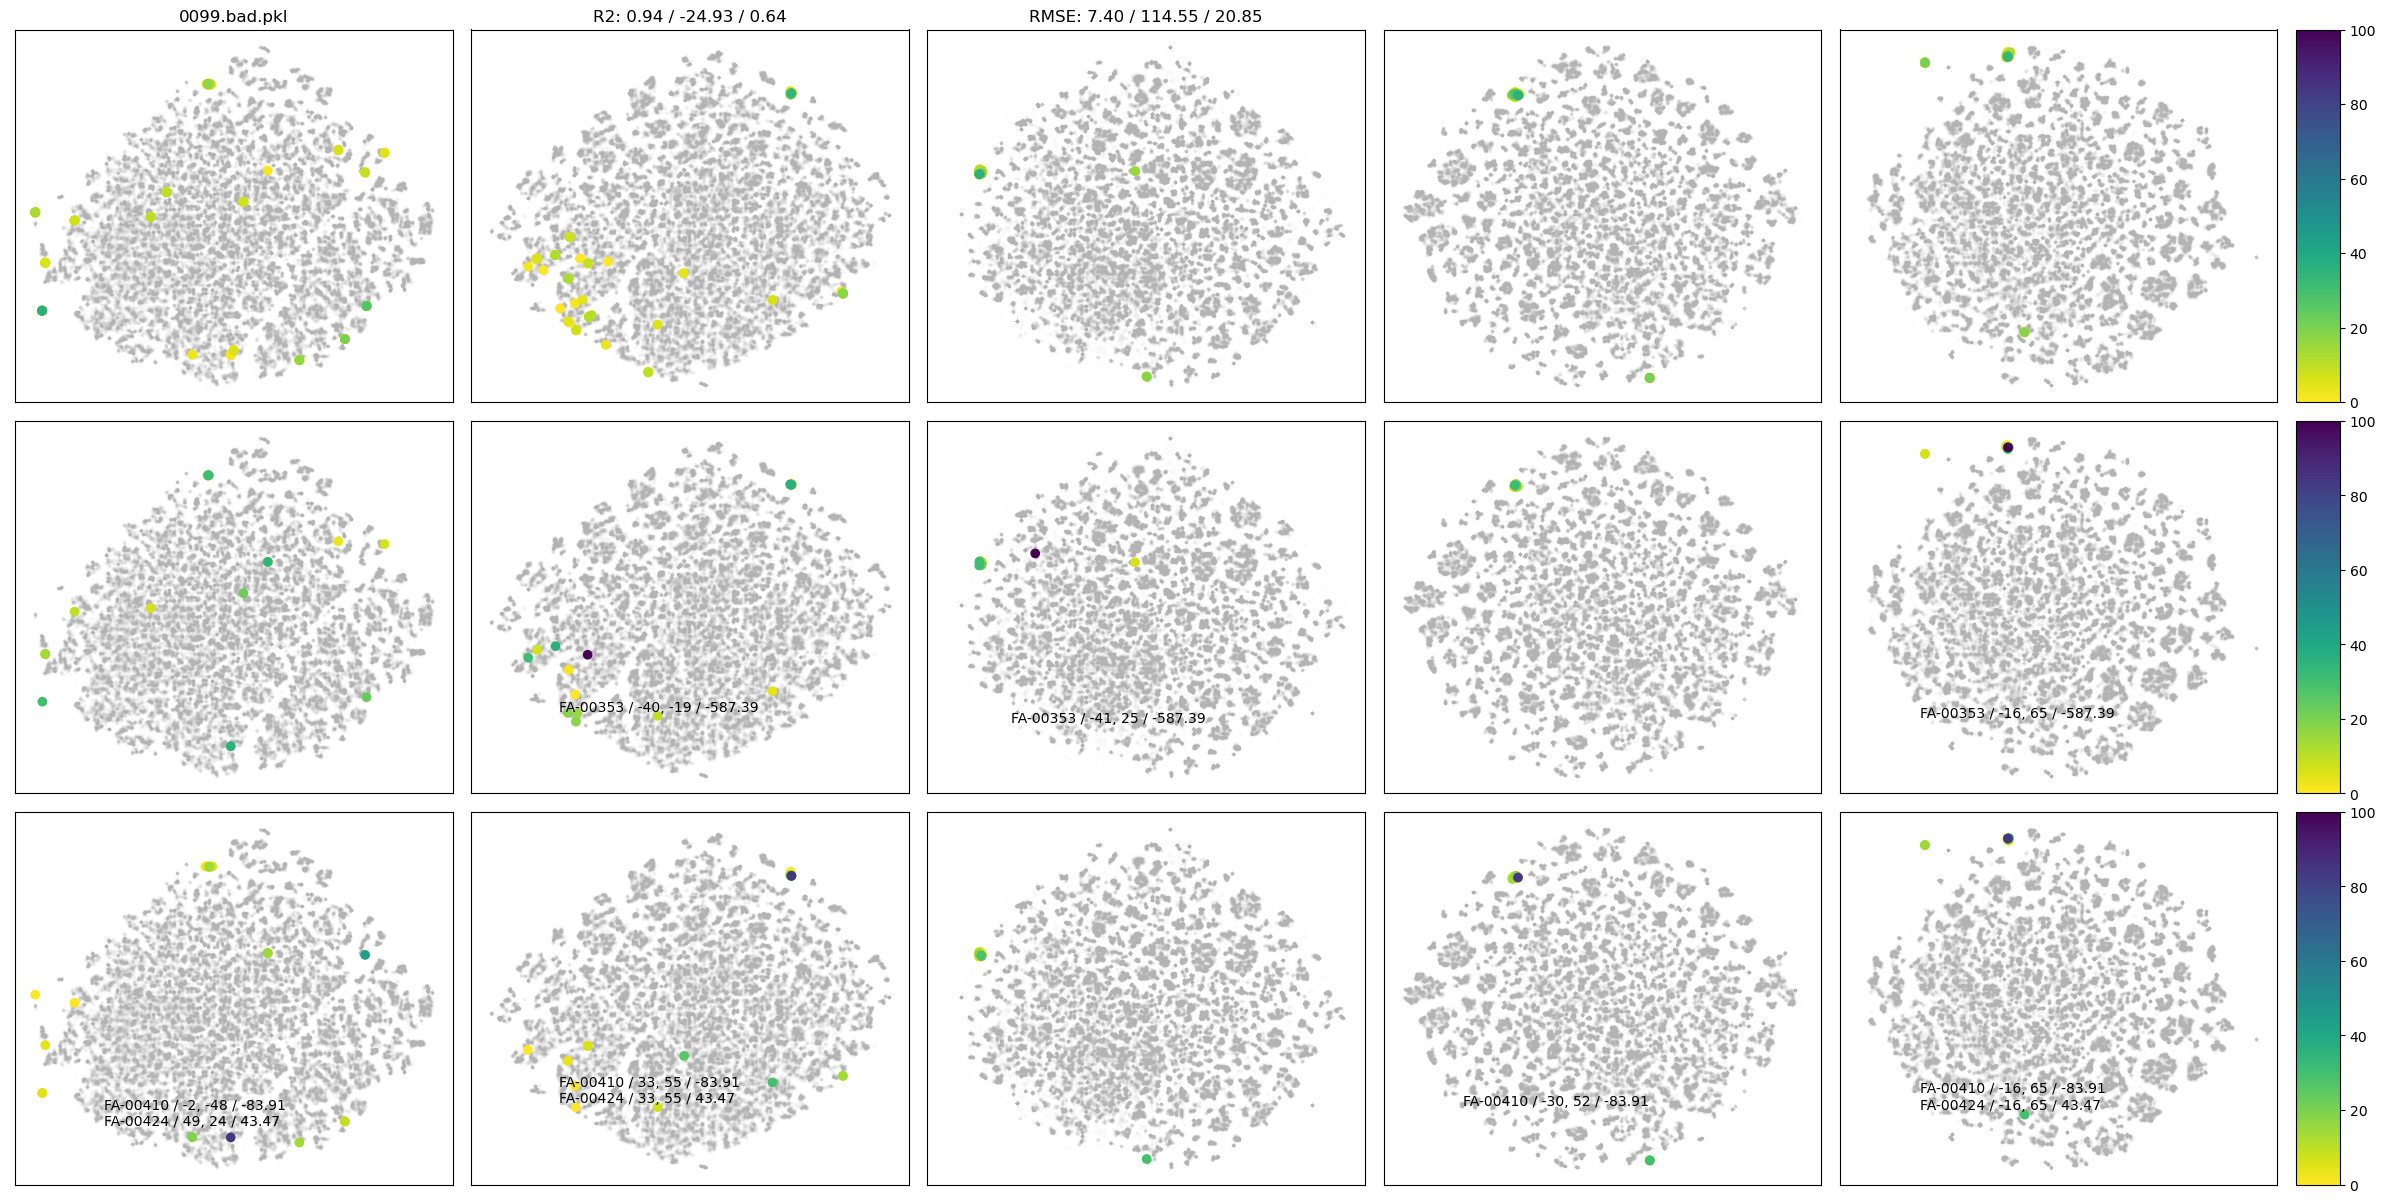

In [56]:
root = '/home/jhyang/WORKSPACES/tsne_gpu/'
tag = 'finetune_n1i-01/mol/mult_add_dnn'
fn = '0099.bad.pkl'
plt.ion()
f, df = draw_figures(fn, tag, root)


In [11]:
root = '/home/jhyang/WORKSPACES/tsne_gpu/'
tag = 'finetune_n1i-01/mol/mult_add_dnn'
for fn in os.listdir(os.path.join(root, tag)):
    print(fn)
    data = load_encoded_tvecs(fn, tag, root)
    for id, err in zip(data['ids'], data['err']):
        pdf = pd.DataFrame({'ID':id, 'ERR':err})
        m = pdf.ID.isin(ids_410.values.reshape(-1))
        print(pdf.loc[m, ['ID','ERR']].values)

0064.good.pkl
[['FA-00202' 4.601749420166016]
 ['FA-00203' 3.1471099853515625]
 ['FA-00350' 0.15330886840820312]
 ['FA-00422' -10.377498626708984]]
[]
[['FA-00410' -73.0976333618164]]
0099.bad.pkl
[['FA-00203' 0.27042388916015625]
 ['FA-00350' -0.50445556640625]]
[['FA-00202' -7.3566436767578125]
 ['FA-00422' -36.56993865966797]]
[['FA-00410' -83.91492462158203]]
0003.bad.pkl
[['FA-00202' -9.07297134399414]
 ['FA-00203' -4.874717712402344]
 ['FA-00350' -1.4397315979003906]]
[['FA-00422' -20.66607666015625]]
[['FA-00410' -83.70116424560547]]
0007.bad.pkl
[['FA-00202' -1.9315719604492188]
 ['FA-00350' 1.3628082275390625]
 ['FA-00422' -7.226448059082031]]
[['FA-00203' 3.41705322265625]]
[['FA-00410' -70.35218811035156]]
0069.bad.pkl
[['FA-00202' -0.42833709716796875]
 ['FA-00203' 4.7425994873046875]
 ['FA-00350' 2.2918777465820312]
 ['FA-00422' -9.357582092285156]]
[]
[['FA-00410' -76.14422607421875]]
0010.good.pkl
[['FA-00202' -6.866619110107422]
 ['FA-00203' 1.789703369140625]
 ['FA-003

### molecular feature

In [89]:
df = pd.read_csv('../dataset/fpolymers_221123.csv')
df = df[~df['TG'].isna()]
saved_smiles = []
masks = []
for x in 'ABCDE':
    smiles_unique = df[f'SMILES_{x}'].drop_duplicates().values
    smiles = df[f'SMILES_{x}']
    weight = df[f'FR_{x}']
    count = 0
    max_smiles = smiles[0]
    for smiles_ in smiles_unique:
        n = np.sum(smiles == smiles_)
        if n > count:
            max_smiles = smiles_
            count = n
    saved_smiles.append(max_smiles)
    masks.append((smiles == max_smiles) | (weight == 0))
    print(x, len(smiles), '/', max_smiles, count, np.sum(masks[-1]))

A 294 / CC(=C)C(=O)OCC(C(F)(F)F)(F)F 113 118
B 294 / CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C 173 185
C 294 / COC(=O)C(C)=C 281 283
D 294 / CC(=C)C(O)=O 276 278
E 294 / CC(=C)C(=O)OCCO 254 254


In [88]:
np.sum((masks[2] & masks[3]) & masks[4])

245

### atomic feature

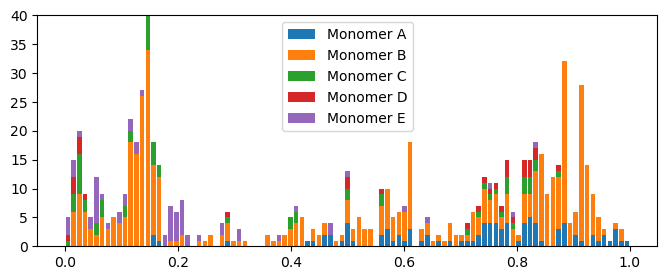

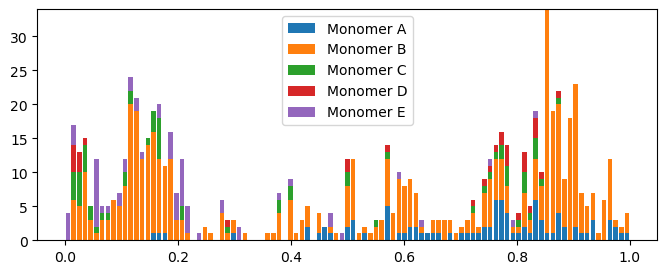

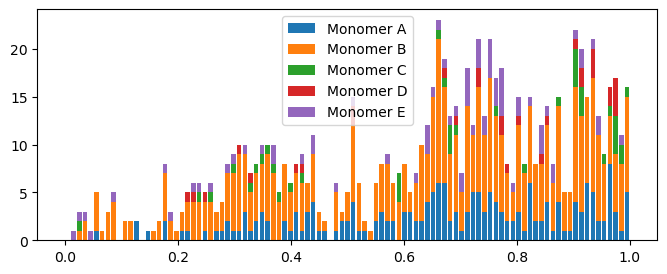

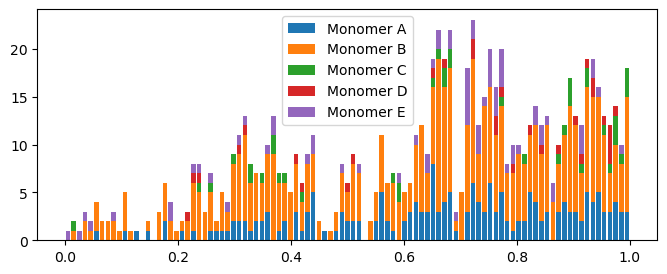

In [246]:
n = hcg_q.shape[0]
for vecs in [vecs1, vecs1_3d, vecs2, vecs2_3d]:
    v1 = vecs[:n]
    v2 = vecs[n:]
    diff = np.stack([v1.T[i].reshape(-1,1) - v2.T[i].reshape(1,-1) for i in range(v1.shape[1])], axis=0)
    dist = np.sqrt(np.sum(np.square(diff), axis=0)).T
    f, ax = plt.subplots(1, 1, figsize=(8, 3))
    bins = 100
    bmax = 1
    b = np.linspace(0, bmax, bins)
    _c = np.zeros(bins - 1)
    for i in range(5):
        i1, i2 = np.sum(lengths[:i], dtype=int), np.sum(lengths[:i+1], dtype=int)
        d = dist[i1:i2].reshape(-1)
        c, x = np.histogram(d, bins=b)
        x = (x[1:] + x[:-1]) * 0.5
        ax.bar(x, c, bottom=_c, width=0.8*bmax/bins, label=f'Monomer {"ABCDE"[i]}')
        _c += c
    ax.legend(loc='upper center')


In [3]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
MolsToGridImage([MolFromSmiles(s) for s in np.hstack(fsmiles)[mask]])

NameError: name 'fsmiles' is not defined

In [18]:
smiles = np.unique(df[col_s].values.reshape(-1))
mol_f = [MolFromSmiles(s) for s in smiles if 'F' in s]
mol_c = [MolFromSmiles(s) for s in smiles if 'F' not in s]
len(mol_f), len(mol_c)

(20, 39)

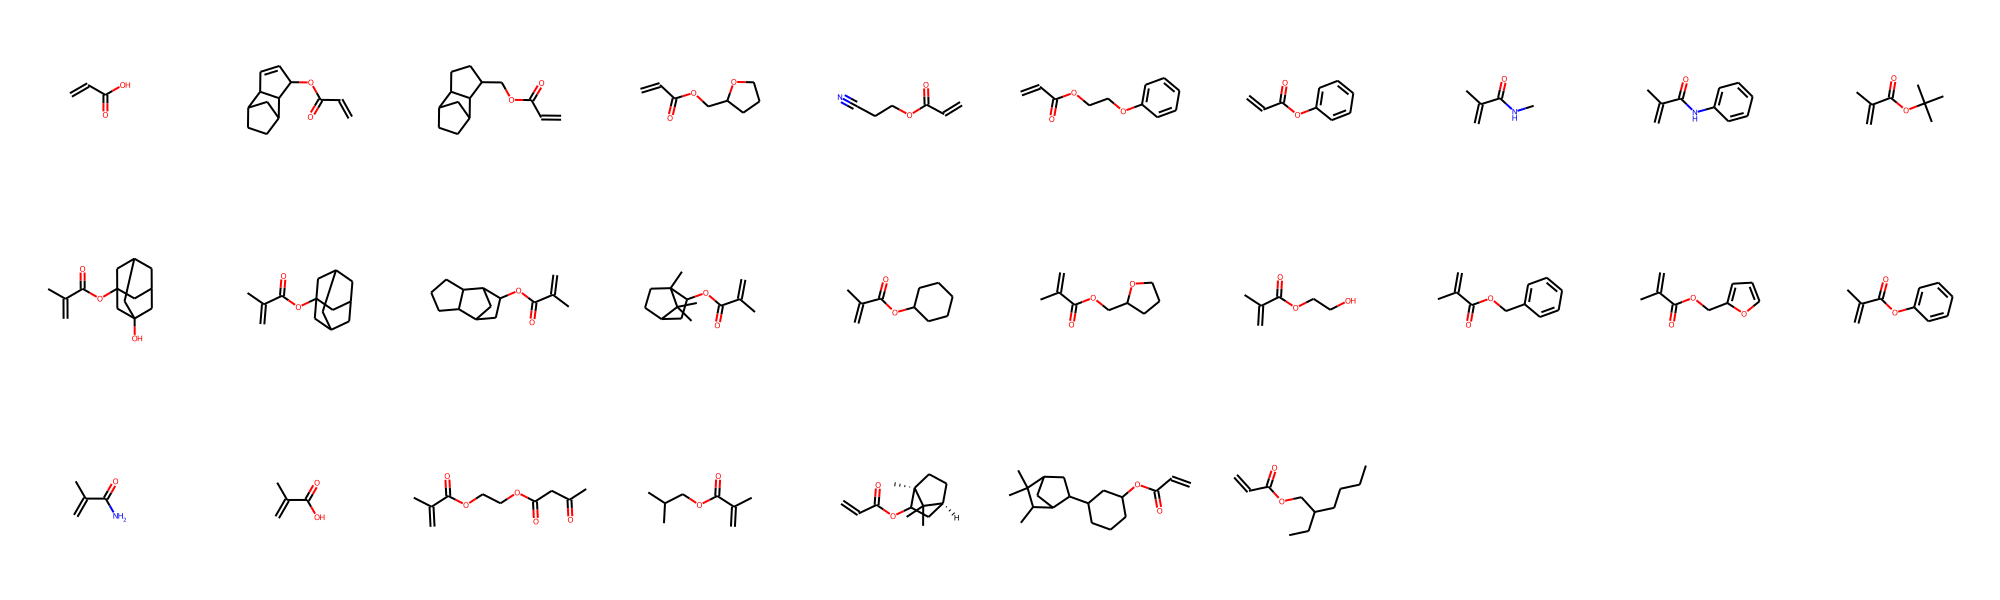

In [17]:
MolsToGridImage(mol_c[:27], molsPerRow=10)

[33, 254, 7]


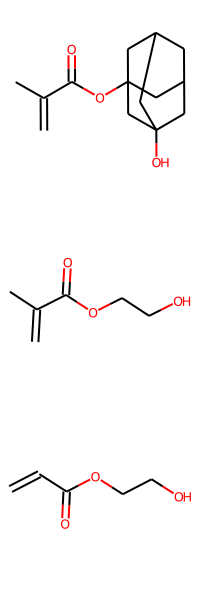

In [23]:
es = np.unique(df.SMILES_E.values)
print([np.sum(df.SMILES_E.values == s) for s in es])
MolsToGridImage([MolFromSmiles(s) for s in es], molsPerRow=1)


In [52]:
odf = pd.read_csv('../dataset/fpolymers_221123.csv')
odf = odf[~odf.TG.isna()]
mask = odf.ID.isin(test_ids).values

dfs = []
for i in range(5):
    for j in range(2):
        qdf = pd.DataFrame()
#        qdf[['tsne_x','tsne_y']] = qvecs[i,j]
#        qdf['Encoder'] = 'ABCDE'[i]
#        qdf['Graph'] = ['cg','tf'][j]
#        qdf['Dataset'] = 'QM9'
        
        fdf = pd.DataFrame()
        fdf[['tsne_x','tsne_y']] = fvecs[i,j]
        fdf['Encoder'] = 'ABCDE'[i]
        fdf['Graph'] = ['cg','tf'][j]
        fdf['Dataset'] = 'Train/Valid'
        fdf['ID'] = odf.ID
        fdf.loc[mask, 'Dataset'] = 'Test'

        dfs.extend([qdf, fdf])
df = pd.concat(dfs)

## Prediction performance

/tmp/ipykernel_302415/1074267693.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  p1 = df.loc[g, ('rmse','value')]
/tmp/ipykernel_302415/1074267693.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  p2 = df.loc[g, ('rmse','err')]
/tmp/ipykernel_302415/1074267693.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  p1 = df.loc[g, ('r2','value')]
/tmp/ipykernel_302415/1074267693.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  p2 = df.loc[g, ('r2','err')]


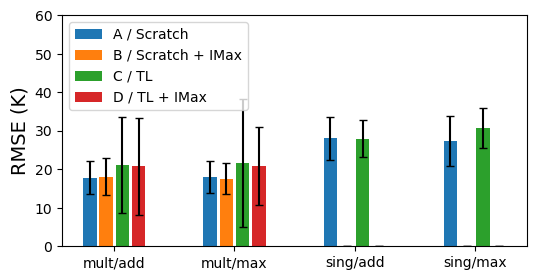

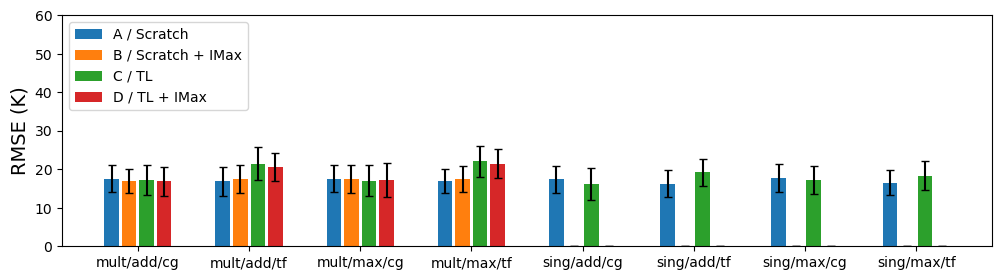

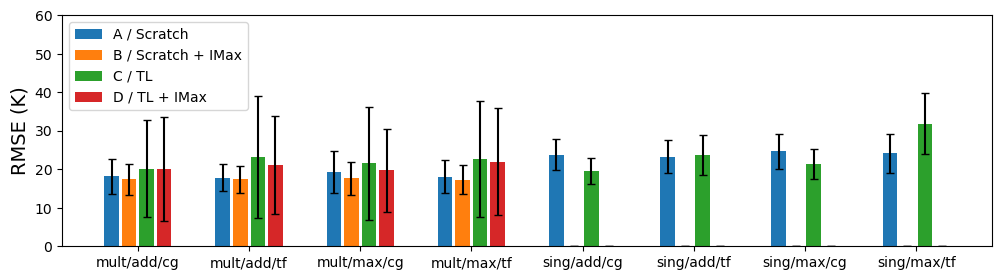

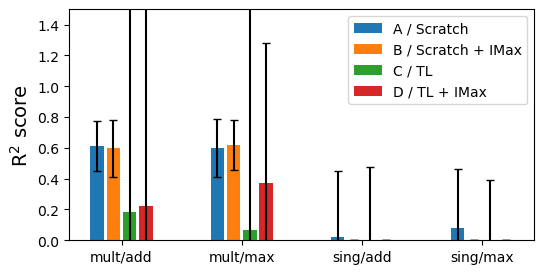

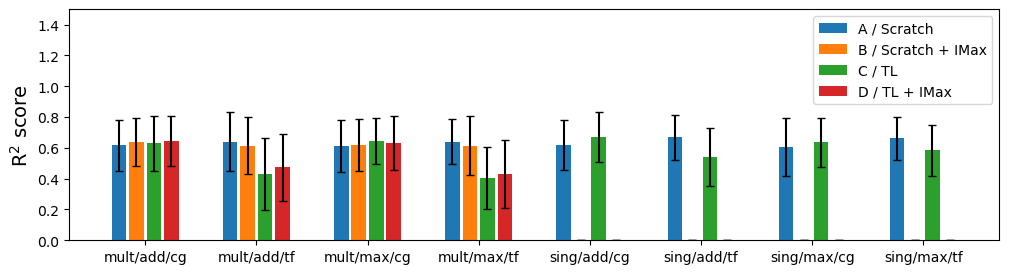

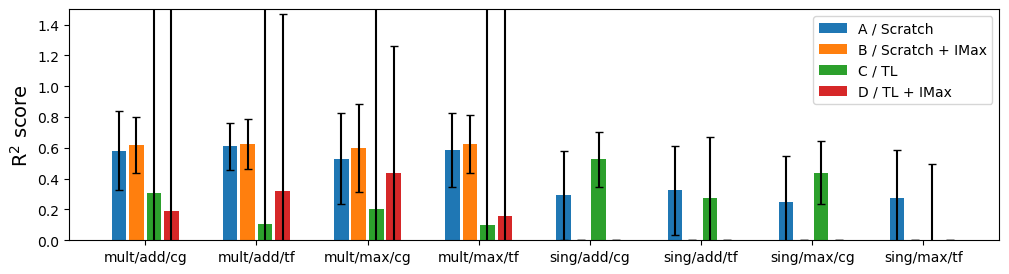

In [86]:
labels = ['A / Scratch', 'B / Scratch + IMax', 'C / TL', 'D / TL + IMax']
df = pd.read_csv('../mat.csv', index_col=[0,1,2,3], header=[0,1,2])
df[df.isna()] = 0

for g in ['mol','graph','cat']:
    p1 = df.loc[g, ('rmse','value')]
    p2 = df.loc[g, ('rmse','err')]
    p1.shape[0]
    f, ax = plt.subplots(1,1,figsize=(p1.shape[0]*1.5,3))
    for i, ((idx, v), (_, e)) in enumerate(zip(p1.T.iterrows(), p2.T.iterrows())):
        ax.bar(i*0.18 + np.linspace(0, len(v), len(v)), v.values, width=0.15, label=labels[i])
        ax.errorbar(i*0.18 + np.linspace(0, len(v), len(v)), v.values, e.values, color=[0,0,0], ls='', fmt='', capsize=3)
    xlabels = []
    for i, _ in p1.iterrows():
        xlabels.append('/'.join(i) if g != 'mol' else '/'.join(i[:-1]))
    ax.legend(loc='upper left')
    ax.set_ylabel('RMSE (K)', fontsize=14)
    ax.set_xticks(np.linspace(0,len(v), len(v))+0.27, labels=xlabels)
    ax.set_ylim([0, 60])
    

for g in ['mol','graph','cat']:
    p1 = df.loc[g, ('r2','value')]
    p2 = df.loc[g, ('r2','err')]
    p1.shape[0]
    f, ax = plt.subplots(1,1,figsize=(p1.shape[0]*1.5,3))
    for i, ((idx, v), (_, e)) in enumerate(zip(p1.T.iterrows(), p2.T.iterrows())):
        ax.bar(i*0.18 + np.linspace(0, len(v), len(v)), v.values, width=0.15, label=labels[i])
        ax.errorbar(i*0.18 + np.linspace(0, len(v), len(v)), v.values, e.values, color=[0,0,0], ls='', fmt='', capsize=3)
    xlabels = []
    for i, _ in p1.iterrows():
        xlabels.append('/'.join(i) if g != 'mol' else '/'.join(i[:-1]))
    ax.legend(loc='upper right')
    ax.set_ylabel('R$^2$ score', fontsize=14)
    ax.set_xticks(np.linspace(0,len(v), len(v))+0.27, labels=xlabels)
    ax.set_ylim([0, 1.5])

In [25]:
from scipy.stats import gaussian_kde

gaussian_kde()

In [26]:
df = pd.read_csv('../dataset/fpolymers_221123.csv', index_col=0)
df = df[~df.TG.isna()]
root = '/home/jhyang/WORKSPACES/vecs/feat'
ids  = json.load(open(os.path.join(root, 'ids.txt')))
vecs = np.loadtxt(os.path.join(root, 'mol_max_u.txt'))
info = pd.read_csv(os.path.join('../dataset/screen_02.csv'))
rinfo = pd.read_csv(os.path.join('../dataset/screen_02.csv'))
n = df.shape[0]
ids[n], n, info.shape, rinfo.shape, vecs.shape

('0', 294, (228720, 13), (228720, 13), (229014, 399))